In [60]:
import polars as pl
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from vxx_trade.data_generator import generate_data_for_strategy
import matplotlib.pyplot as plt
import itertools
from scipy.stats import spearmanr

In [36]:
def foo():
    datagen = generate_data_for_strategy(verbose=False)
    df = datagen()

    features = [
        "volume",
        "vix_cp",
        "vvix_cp",
        "vol_ts",
        "vix_cp_ewma_zscore",
        "vvix_cp_ewma_zscore",
        "vol_ts_ewma_zscore",
    ]

    cols_to_keep = features + ["date", "vix_cp_rank", "vol_ts_rank", "vvix_cp_rank","vix_cp_zscore_bucket","vvix_cp_zscore_bucket","vol_ts_zscore_bucket","cc_ret"]

    scaling_features = features[:4]

    df = df.with_columns(
        [
            (pl.col(name) - pl.mean(name)) / pl.std(name) for name in scaling_features
        ]
    )
    df = df.select(cols_to_keep).drop_nulls()
    kmeans = KMeans(n_clusters=10, random_state=42)
    kmeans.fit(df.select(features).to_numpy())
    df = df.with_columns(pl.Series(kmeans.labels_.astype("int")).alias("KMeansCluster"))

    hierarchical_clustering = AgglomerativeClustering(n_clusters=10)
    hierarchical_clustering.fit(df.select(features).to_numpy())
    df = df.with_columns(
        pl.Series(hierarchical_clustering.labels_.astype("int")).alias(
            "HierarchicalCluster"
        )
    )

    gmm = GaussianMixture(n_components=10, random_state=42)  
    gmm.fit(df.select(features).to_numpy())
    df = df.with_columns(
        pl.Series(gmm.predict(df.select(features).to_numpy()).astype("int")).alias("GMMCluster")
    )

    return df 

In [23]:
def plot_clusters(df):
    cluster_cols = ["KMeansCluster", "HierarchicalCluster", "GMMCluster", "vix_cp_rank"]

    for col in cluster_cols:
        print(df.group_by(col).agg(
            [
                pl.std("cc_ret").alias("std_cc_ret"),
                (pl.col("cc_ret").abs() * 252 ** 0.5).abs().mean().alias("annualized_cc_ret_vol"),
                pl.col("cc_ret").count().alias("GroupCount"),
            ]
        ).sort("std_cc_ret"))


In [45]:
def compute_ret_sharpe(df):
    cluster_cols = ["KMeansCluster", "HierarchicalCluster", "GMMCluster", "vix_cp_rank"]

    df = df.with_columns(
        [
            (pl.col("cc_ret") * 252 / (pl.col("cc_ret").abs() * 252 ** 0.5).mean()).alias(f"{col}_sharpe").over(col) for col in cluster_cols
        ]
    )

    return df

In [37]:
df = foo()

In [35]:
plot_clusters(df)

shape: (10, 4)
┌───────────────┬────────────┬───────────────────────┬────────────┐
│ KMeansCluster ┆ std_cc_ret ┆ annualized_cc_ret_vol ┆ GroupCount │
│ ---           ┆ ---        ┆ ---                   ┆ ---        │
│ i64           ┆ f32        ┆ f32                   ┆ u32        │
╞═══════════════╪════════════╪═══════════════════════╪════════════╡
│ 4             ┆ 0.025364   ┆ 0.291461              ┆ 704        │
│ 0             ┆ 0.027553   ┆ 0.323334              ┆ 561        │
│ 3             ┆ 0.032288   ┆ 0.389549              ┆ 346        │
│ 5             ┆ 0.035447   ┆ 0.427695              ┆ 308        │
│ 1             ┆ 0.045317   ┆ 0.533565              ┆ 509        │
│ 9             ┆ 0.050934   ┆ 0.611824              ┆ 258        │
│ 8             ┆ 0.054195   ┆ 0.670621              ┆ 182        │
│ 6             ┆ 0.064502   ┆ 0.83661               ┆ 153        │
│ 7             ┆ 0.105005   ┆ 1.201387              ┆ 53         │
│ 2             ┆ 0.12649    ┆ 1.

In [47]:
calc = compute_ret_sharpe(df)

In [44]:
df

volume,vix_cp,vvix_cp,vol_ts,vix_cp_ewma_zscore,vvix_cp_ewma_zscore,vol_ts_ewma_zscore,date,vix_cp_rank,vol_ts_rank,vvix_cp_rank,vix_cp_zscore_bucket,vvix_cp_zscore_bucket,vol_ts_zscore_bucket,cc_ret,KMeansCluster,HierarchicalCluster,GMMCluster
f64,f32,f32,f64,f32,f32,f64,date,u32,u32,u32,cat,cat,cat,f32,i64,i64,i64
0.046065,-0.218324,-0.118183,-0.516294,-1.22762,-0.480111,-0.978408,2012-07-18,6,4,6,"""(-1.5, -1]""","""(-0.5, 0]""","""(-1, -0.5]""",-0.023623,4,9,4
-0.052626,-0.323668,-0.136053,-0.826688,-1.424321,-0.49673,-1.770495,2012-07-19,5,3,6,"""(-1.5, -1]""","""(-0.5, 0]""","""(-2, -1.5]""",0.050496,4,9,4
0.352964,-0.202003,0.273758,-0.850786,-1.029748,0.44982,-1.716744,2012-07-20,6,2,7,"""(-1.5, -1]""","""(0, 0.5]""","""(-2, -1.5]""",0.063117,3,9,4
0.778042,0.14667,0.673442,-0.166953,-0.077099,1.308013,0.222489,2012-07-23,7,5,8,"""(-0.5, 0]""","""(1, 1.5]""","""(0, 0.5]""",0.041789,1,4,6
0.666231,0.421157,0.931361,0.378488,0.636342,1.77094,1.659415,2012-07-24,8,7,9,"""(0.5, 1]""","""(1.5, 2]""","""(1.5, 2]""",-0.014428,9,2,6
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-0.968412,0.23866,0.720499,0.92444,0.140222,0.076387,0.443714,2024-10-23,8,9,8,"""(0, 0.5]""","""(0, 0.5]""","""(0, 0.5]""",-0.017085,5,8,6
-1.019362,0.214921,0.823547,0.939665,0.096099,0.170154,0.443061,2024-10-24,8,9,9,"""(0, 0.5]""","""(0, 0.5]""","""(0, 0.5]""",0.045892,5,8,9
-0.994622,0.400385,1.279819,1.069907,0.387519,0.597521,0.577615,2024-10-25,8,9,9,"""(0, 0.5]""","""(0.5, 1]""","""(0.5, 1]""",-0.047787,9,8,6


In [48]:
calc

volume,vix_cp,vvix_cp,vol_ts,vix_cp_ewma_zscore,vvix_cp_ewma_zscore,vol_ts_ewma_zscore,date,vix_cp_rank,vol_ts_rank,vvix_cp_rank,vix_cp_zscore_bucket,vvix_cp_zscore_bucket,vol_ts_zscore_bucket,cc_ret,KMeansCluster,HierarchicalCluster,GMMCluster,KMeansCluster_sharpe,HierarchicalCluster_sharpe,GMMCluster_sharpe,vix_cp_rank_sharpe
f64,f32,f32,f64,f32,f32,f64,date,u32,u32,u32,cat,cat,cat,f32,i64,i64,i64,f32,f32,f32,f32
0.046065,-0.218324,-0.118183,-0.516294,-1.22762,-0.480111,-0.978408,2012-07-18,6,4,6,"""(-1.5, -1]""","""(-0.5, 0]""","""(-1, -0.5]""",-0.023623,4,9,4,-20.425051,-20.034842,-16.89967,-11.904978
-0.052626,-0.323668,-0.136053,-0.826688,-1.424321,-0.49673,-1.770495,2012-07-19,5,3,6,"""(-1.5, -1]""","""(-0.5, 0]""","""(-2, -1.5]""",0.050496,4,9,4,43.659363,42.825272,36.123718,30.367434
0.352964,-0.202003,0.273758,-0.850786,-1.029748,0.44982,-1.716744,2012-07-20,6,2,7,"""(-1.5, -1]""","""(0, 0.5]""","""(-2, -1.5]""",0.063117,3,9,4,40.83049,53.528961,45.152431,31.807644
0.778042,0.14667,0.673442,-0.166953,-0.077099,1.308013,0.222489,2012-07-23,7,5,8,"""(-0.5, 0]""","""(1, 1.5]""","""(0, 0.5]""",0.041789,1,4,6,19.736738,17.322563,13.975712,16.522739
0.666231,0.421157,0.931361,0.378488,0.636342,1.77094,1.659415,2012-07-24,8,7,9,"""(0.5, 1]""","""(1.5, 2]""","""(1.5, 2]""",-0.014428,9,2,6,-5.942707,-5.278871,-4.825271,-6.687803
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-0.968412,0.23866,0.720499,0.92444,0.140222,0.076387,0.443714,2024-10-23,8,9,8,"""(0, 0.5]""","""(0, 0.5]""","""(0, 0.5]""",-0.017085,5,8,6,-10.066459,-7.742039,-5.713763,-7.919249
-1.019362,0.214921,0.823547,0.939665,0.096099,0.170154,0.443061,2024-10-24,8,9,9,"""(0, 0.5]""","""(0, 0.5]""","""(0, 0.5]""",0.045892,5,8,9,27.03948,20.795866,22.602047,21.271868
-0.994622,0.400385,1.279819,1.069907,0.387519,0.597521,0.577615,2024-10-25,8,9,9,"""(0, 0.5]""","""(0.5, 1]""","""(0.5, 1]""",-0.047787,9,8,6,-19.682638,-21.654783,-15.981616,-22.150446


In [50]:
calc.describe()

statistic,volume,vix_cp,vvix_cp,vol_ts,vix_cp_ewma_zscore,vvix_cp_ewma_zscore,vol_ts_ewma_zscore,date,vix_cp_rank,vol_ts_rank,vvix_cp_rank,vix_cp_zscore_bucket,vvix_cp_zscore_bucket,vol_ts_zscore_bucket,cc_ret,KMeansCluster,HierarchicalCluster,GMMCluster,KMeansCluster_sharpe,HierarchicalCluster_sharpe,GMMCluster_sharpe,vix_cp_rank_sharpe
str,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",3093.0,3093.0,3093.0,3093.0,3093.0,3093.0,3093.0,"""3093""",3093.0,3093.0,3093.0,"""3093""","""3093""","""3093""",3093.0,3093.0,3093.0,3093.0,3093.0,3093.0,3093.0,3093.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,"""0""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",-0.010409,-0.00701,-0.004404,0.000798,-0.044132,-0.006829,-0.000297,"""2018-09-28 14:48:18.157000""",5.459425,5.495959,5.47462,null,null,null,-0.002675,3.559004,4.967346,3.406078,-1.571677,-1.572459,-1.522458,-1.40687
"""std""",1.004669,1.007279,1.00735,1.008483,1.147466,1.119027,1.119252,null,2.878757,2.892489,2.886784,null,null,null,0.041706,2.793941,3.202608,2.84291,21.228367,21.272551,21.443949,21.855436
"""min""",-1.154899,-1.259892,-2.040363,-2.13758,-2.530616,-2.565748,-3.69631,"""2012-07-18""",1.0,1.0,1.0,null,null,null,-0.213705,0.0,0.0,0.0,-77.67968,-78.374901,-93.005836,-82.828789
"""25%""",-0.782646,-0.651569,-0.718008,-0.700423,-0.8095,-0.718448,-0.781784,"""2015-09-03""",3.0,3.0,3.0,null,null,null,-0.024866,1.0,3.0,1.0,-15.141395,-14.948025,-14.895185,-14.675296
"""50%""",-0.179163,-0.293994,-0.22838,-0.109291,-0.316245,-0.200924,-0.158486,"""2018-10-02""",5.0,5.0,5.0,null,null,null,-0.0059,4.0,4.0,4.0,-3.809278,-3.963289,-3.878259,-3.956806
"""75%""",0.4141,0.35439,0.588264,0.583474,0.481628,0.501,0.638341,"""2021-10-27""",8.0,8.0,8.0,null,null,null,0.014488,5.0,9.0,5.0,8.753476,8.652567,8.692134,8.614246
"""max""",8.174324,9.652829,6.646076,6.096869,7.400439,6.735384,6.252246,"""2024-10-29""",10.0,10.0,10.0,null,null,null,0.33085,9.0,9.0,9.0,159.900787,156.845978,162.771866,159.282257


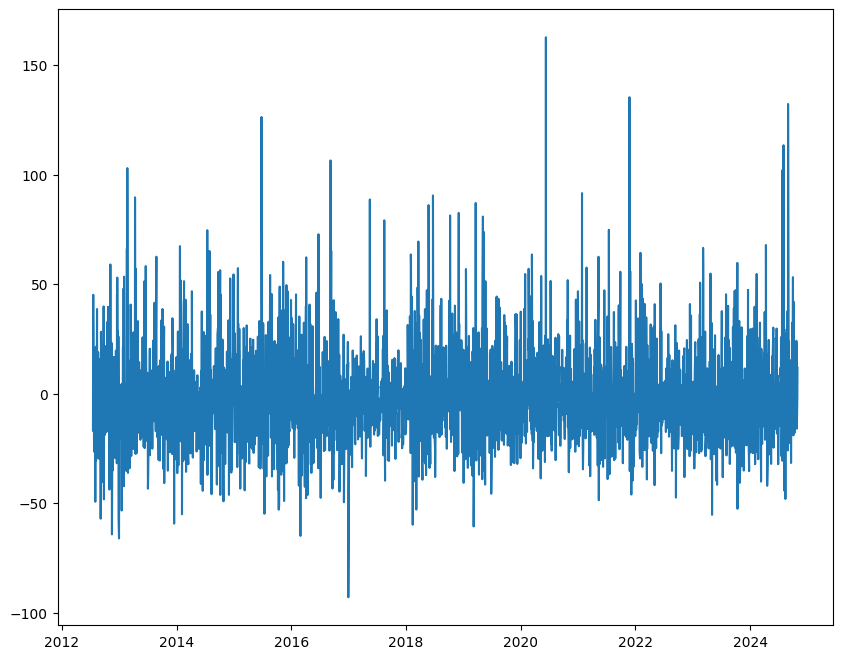

In [54]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(calc.get_column('date'), calc.get_column('GMMCluster_sharpe'))

In [58]:
def calculate_spearman_correlation_polars(df, col1, col2):
    """
    Calculates the Spearman correlation coefficient between two columns of a Polars DataFrame.

    Args:
        df (pl.DataFrame): The Polars DataFrame.
        col1 (str): The name of the first column.
        col2 (str): The name of the second column.

    Returns:
        tuple: A tuple containing the Spearman correlation coefficient and the p-value.
    """
    

    series1 = df.select(col1).to_series()
    series2 = df.select(col2).to_series()
    correlation, p_value = spearmanr(series1, series2)
    print(f'{col1} correlation with {col2} is {correlation:.3f}')
    return correlation, p_value

In [61]:
cols = "KMeansCluster_sharpe HierarchicalCluster_sharpe GMMCluster_sharpe vix_cp_rank_sharpe".split()
for col1, col2 in list(itertools.combinations(cols, 2)):
    calculate_spearman_correlation_polars(calc, col1, col2)

KMeansCluster_sharpe correlation with HierarchicalCluster_sharpe is 0.993
KMeansCluster_sharpe correlation with GMMCluster_sharpe is 0.988
KMeansCluster_sharpe correlation with vix_cp_rank_sharpe is 0.981
HierarchicalCluster_sharpe correlation with GMMCluster_sharpe is 0.989
HierarchicalCluster_sharpe correlation with vix_cp_rank_sharpe is 0.980
GMMCluster_sharpe correlation with vix_cp_rank_sharpe is 0.982


In [65]:
calc.with_columns([
    

            (
                (
                    pl.col(column).rank(method="max", descending=False)
                    / df.height
                    * 10
                )
                .ceil()
                .cast(pl.UInt32)
                .alias(f"{column}_rank")
            )
for column in cols]
        )

volume,vix_cp,vvix_cp,vol_ts,vix_cp_ewma_zscore,vvix_cp_ewma_zscore,vol_ts_ewma_zscore,date,vix_cp_rank,vol_ts_rank,vvix_cp_rank,vix_cp_zscore_bucket,vvix_cp_zscore_bucket,vol_ts_zscore_bucket,cc_ret,KMeansCluster,HierarchicalCluster,GMMCluster,KMeansCluster_sharpe,HierarchicalCluster_sharpe,GMMCluster_sharpe,vix_cp_rank_sharpe,KMeansCluster_sharpe_rank,HierarchicalCluster_sharpe_rank,GMMCluster_sharpe_rank,vix_cp_rank_sharpe_rank
f64,f32,f32,f64,f32,f32,f64,date,u32,u32,u32,cat,cat,cat,f32,i64,i64,i64,f32,f32,f32,f32,u32,u32,u32,u32
0.046065,-0.218324,-0.118183,-0.516294,-1.22762,-0.480111,-0.978408,2012-07-18,6,4,6,"""(-1.5, -1]""","""(-0.5, 0]""","""(-1, -0.5]""",-0.023623,4,9,4,-20.425051,-20.034842,-16.89967,-11.904978,2,2,3,4
-0.052626,-0.323668,-0.136053,-0.826688,-1.424321,-0.49673,-1.770495,2012-07-19,5,3,6,"""(-1.5, -1]""","""(-0.5, 0]""","""(-2, -1.5]""",0.050496,4,9,4,43.659363,42.825272,36.123718,30.367434,10,10,10,10
0.352964,-0.202003,0.273758,-0.850786,-1.029748,0.44982,-1.716744,2012-07-20,6,2,7,"""(-1.5, -1]""","""(0, 0.5]""","""(-2, -1.5]""",0.063117,3,9,4,40.83049,53.528961,45.152431,31.807644,10,10,10,10
0.778042,0.14667,0.673442,-0.166953,-0.077099,1.308013,0.222489,2012-07-23,7,5,8,"""(-0.5, 0]""","""(1, 1.5]""","""(0, 0.5]""",0.041789,1,4,6,19.736738,17.322563,13.975712,16.522739,9,9,9,9
0.666231,0.421157,0.931361,0.378488,0.636342,1.77094,1.659415,2012-07-24,8,7,9,"""(0.5, 1]""","""(1.5, 2]""","""(1.5, 2]""",-0.014428,9,2,6,-5.942707,-5.278871,-4.825271,-6.687803,5,5,5,5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-0.968412,0.23866,0.720499,0.92444,0.140222,0.076387,0.443714,2024-10-23,8,9,8,"""(0, 0.5]""","""(0, 0.5]""","""(0, 0.5]""",-0.017085,5,8,6,-10.066459,-7.742039,-5.713763,-7.919249,4,5,5,4
-1.019362,0.214921,0.823547,0.939665,0.096099,0.170154,0.443061,2024-10-24,8,9,9,"""(0, 0.5]""","""(0, 0.5]""","""(0, 0.5]""",0.045892,5,8,9,27.03948,20.795866,22.602047,21.271868,10,9,9,9
-0.994622,0.400385,1.279819,1.069907,0.387519,0.597521,0.577615,2024-10-25,8,9,9,"""(0, 0.5]""","""(0.5, 1]""","""(0.5, 1]""",-0.047787,9,8,6,-19.682638,-21.654783,-15.981616,-22.150446,2,2,3,2
